# MOODLENS - PHASE 5 PROJECT

In [118]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from textblob import TextBlob
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import csr_matrix

In [119]:
# Loading the dataset
df = pd.read_csv(r"D:\moringa_school\CapStone\final_project\Data\reduced_reddit.csv")
df.head()

,subreddit,title,body,upvotes,created_utc,num_comments,label
0,teenagers,Day 18 of doing 50 push-ups,NaN,4.0,1.619357e+09,4.0,0.0
1,teenagers,There isn’t a better feeling than finishing yo...,Then your teacher hits you with that “ Good jo...,7.0,1.554103e+09,NaN,0.0
2,teenagers,LMAOOO I can only get this guy to talk to me i...,Yeahhh maybe not babe,4.0,1.649342e+09,12.0,0.0
3,teenagers,This isn't going to work out,NaN,236.0,1.417630e+09,33.0,0.0
4,teenagers,Am I the only guy who found it hurtful as a ch...,\n\nLike... why? How is that funny? How does ...,6.0,1.569280e+09,4.0,0.0


In [120]:
# Statistical Summary
df.describe()

,upvotes,created_utc,num_comments,label
count,98826.000000,9.882600e+04,94297.000000,98826.000000
mean,62.315555,1.566569e+09,15.217069,0.194443
std,937.347581,6.977745e+07,71.638197,0.395773
min,4.000000,1.202084e+09,1.000000,0.000000
25%,5.000000,1.552254e+09,4.000000,0.000000
50%,7.000000,1.578218e+09,7.000000,0.000000
75%,11.000000,1.611584e+09,14.000000,0.000000
max,62899.000000,1.672531e+09,7880.000000,1.000000


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          80371 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  94297 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


## Data Cleaning

### Handling missing values

In [122]:
# Checking for missing values in percentage
missing = (df.isnull().sum()/len(df))*100
missing

subreddit        0.000000
title            0.000000
body            18.674236
upvotes          0.000000
created_utc      0.000000
num_comments     4.582802
label            0.000000
dtype: float64

In [123]:
# Filling in for missing values in columns
# The 'Body' column with empty strings and the 'num_comments' with the median

df['num_comments'] = df['num_comments'].fillna(df['num_comments'].median())
df['body'] = df['body'].fillna('')

In [124]:
# Checking for missing values
df.isnull().sum()

subreddit       0
title           0
body            0
upvotes         0
created_utc     0
num_comments    0
label           0
dtype: int64

### Handling duplicates

In [125]:
# Checking for duplicates
df.duplicated().sum()

0

### Handling data format

In [126]:
# Converting created_utc to datetime format 
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
df['created_utc']

0       2021-04-25 13:25:39
1       2019-04-01 07:19:57
2       2022-04-07 14:35:00
3       2014-12-03 18:12:52
4       2019-09-23 23:07:59
                ...        
98821   2019-05-17 08:30:19
98822   2012-10-20 17:24:21
98823   2015-05-19 22:19:26
98824   2012-12-16 15:44:18
98825   2012-02-04 11:36:07
Name: created_utc, Length: 98826, dtype: datetime64[ns]

## EDA

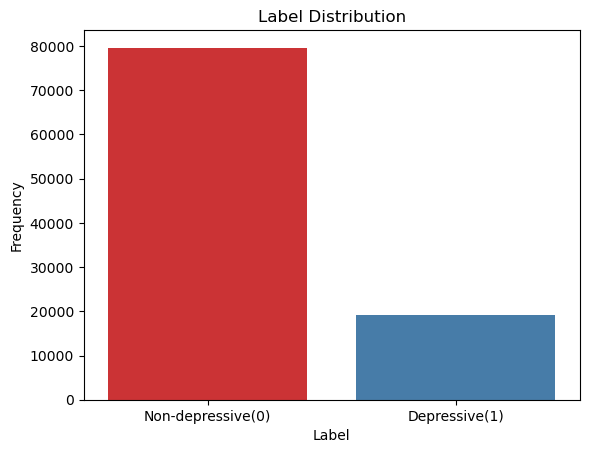

In [127]:
# Plot distribution for the labels(Target variable)
sns.countplot(x='label', data=df, palette='Set1')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Non-depressive(0)', 'Depressive(1)'])
plt.show()

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


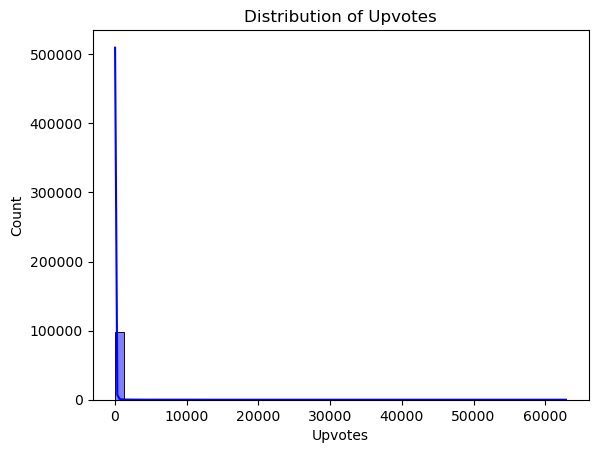

In [128]:
# Plot distribution for upvotes
sns.histplot(df['upvotes'], bins=50, kde=True, color='blue')
plt.title('Distribution of Upvotes')
plt.xlabel('Upvotes')
plt.ylabel('Count')
plt.show()

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


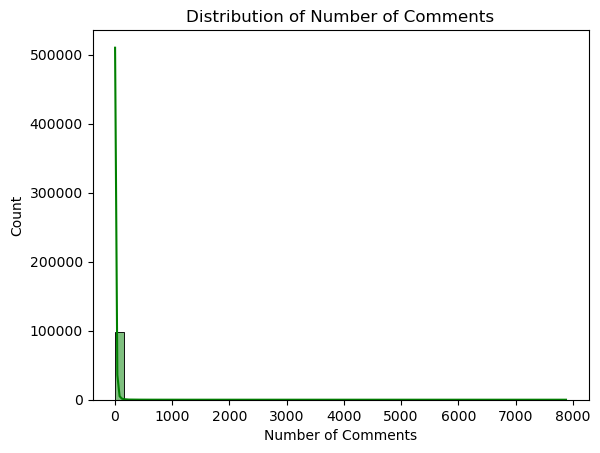

In [129]:
# Plot distribution for Number of Comments 
sns.histplot(df['num_comments'], bins=50, kde=True, color='green')
plt.title('Distribution of Number of Comments')
plt.xlabel('Number of Comments')
plt.ylabel('Count')
plt.show()

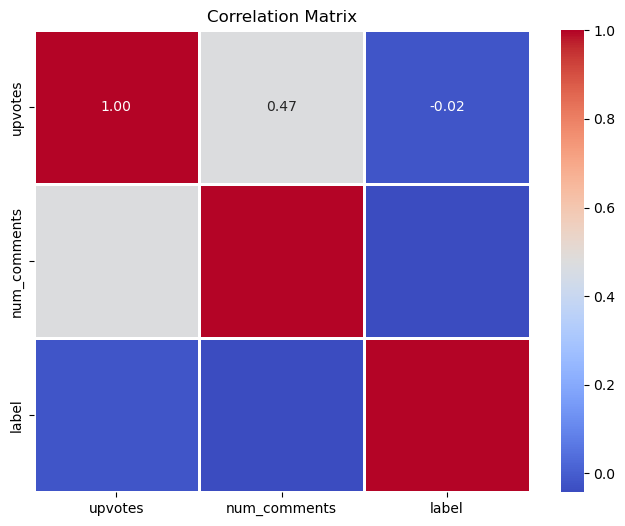

In [130]:
# Plot for correlation matrix of numerical features
plt.figure(figsize=(8, 6))
corr = df[['upvotes', 'num_comments', 'label']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1)
plt.title('Correlation Matrix')
plt.show()

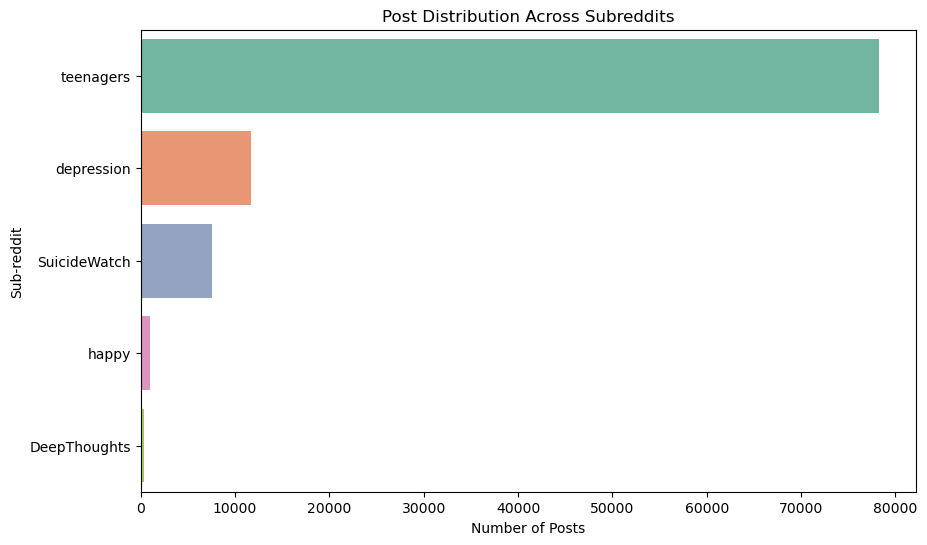

In [131]:
# Plot distribution for Subreddit vs Number of posts 
plt.figure(figsize=(10, 6))
sns.countplot(y='subreddit', data=df, order=df['subreddit'].value_counts().index, palette='Set2')
plt.title('Post Distribution Across Subreddits')
plt.xlabel('Number of Posts')
plt.ylabel('Sub-reddit')
plt.show()

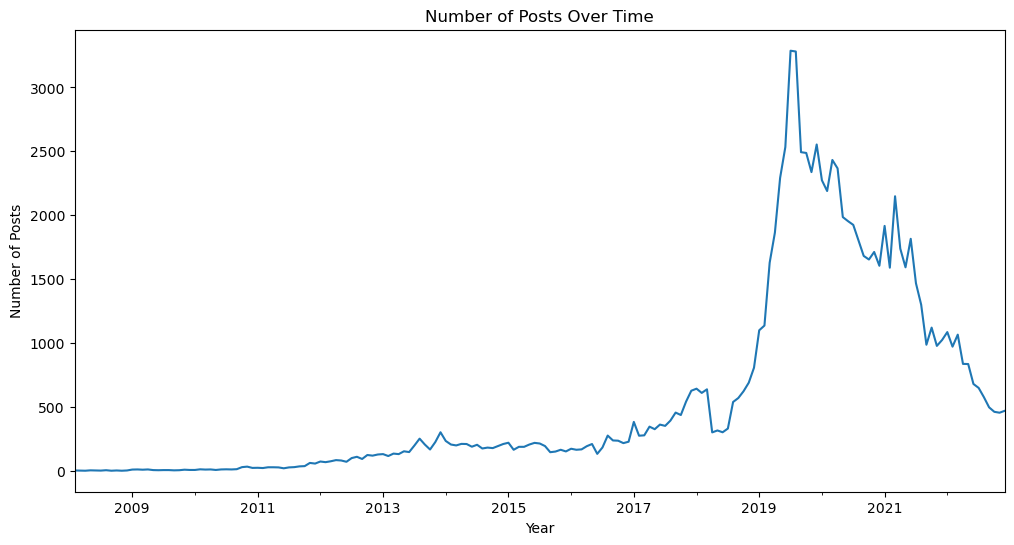

In [132]:
# Converting 'created_utc' to date-time format
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
df.set_index('created_utc', inplace=True)

# Plot trend for number of posts over time
df.resample('M').size().plot(figsize=(12, 6))
plt.title('Number of Posts Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.show()

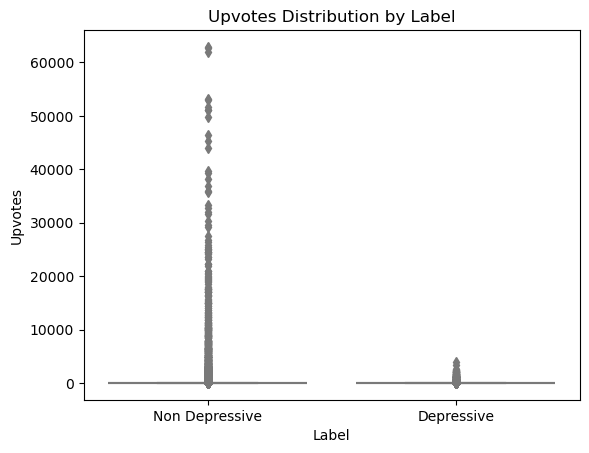

In [133]:
# Boxplot for upvotes and label
sns.boxplot(x='label', y='upvotes', data=df, palette='coolwarm')
plt.title('Upvotes Distribution by Label')
plt.xlabel('Label')
plt.ylabel('Upvotes')
plt.xticks(ticks=[0, 1], labels=['Non Depressive', 'Depressive'])
plt.show()

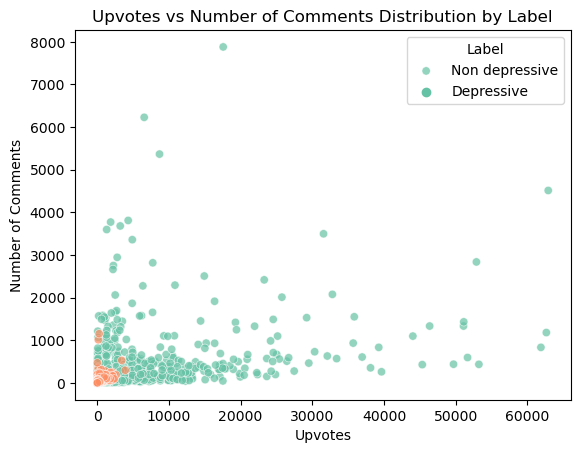

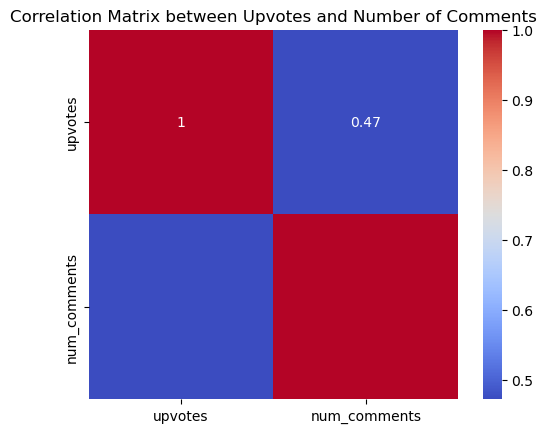

In [134]:
# Scatter Plot: Upvotes vs Number of Comments
sns.scatterplot(x='upvotes', y='num_comments', hue='label', data=df, alpha=0.7, palette='Set2')
plt.title('Upvotes vs Number of Comments Distribution by Label')
plt.ylabel('Number of Comments')
plt.xlabel('Upvotes')
plt.legend(title='Label', labels=['Non depressive', 'Depressive'])
plt.show()
# Building correlation matrix
correlation_matrix = df[['upvotes', 'num_comments']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Matrix between Upvotes and Number of Comments")
plt.show()

### NLP

In [135]:
# Text Preprocessing 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Applying text preprocessing to title and body
df['processed_title'] = df['title'].apply(preprocess_text)
df['processed_body'] = df['body'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Sentiment Analysis

In [140]:
# Using text blob for semtiment analysis
df['title_polarity'] = df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['body_polarity'] = df['body'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Length of title and body
df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split()))
df['body_word_count'] = df['body'].apply(lambda x: len(str(x).split()))

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


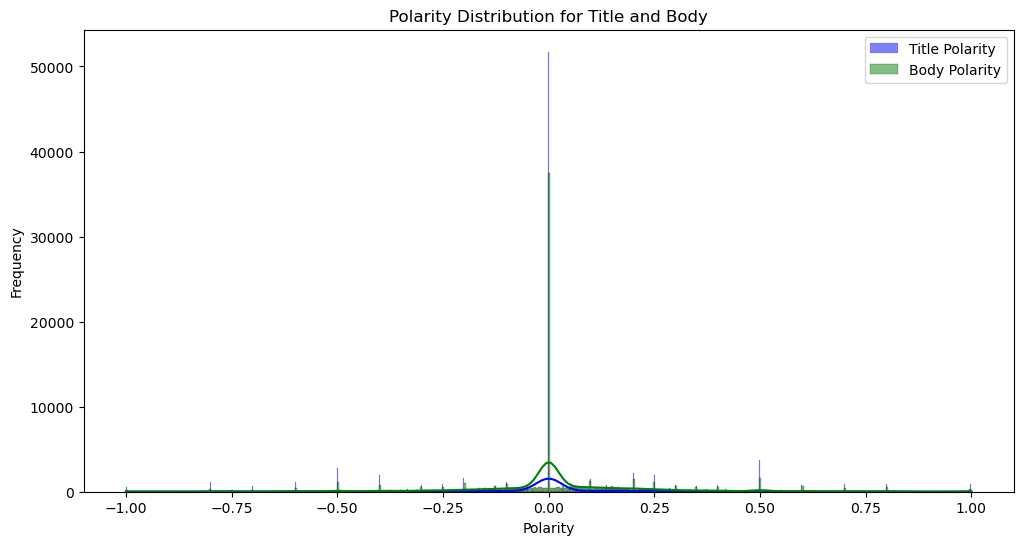

In [141]:
# Plotting the distribution of polarity for the title and body
plt.figure(figsize=(12, 6))
sns.histplot(df['title_polarity'], kde=True, color='blue', label='Title Polarity')
sns.histplot(df['body_polarity'], kde=True, color='green', label='Body Polarity')
plt.title('Polarity Distribution for Title and Body')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [142]:
# Carrying out TF-IDF Vectorization for the body and title columns
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

tfidf_title = tfidf_vectorizer.fit_transform(df['processed_title'])
tfidf_body = tfidf_vectorizer.fit_transform(df['processed_body'])

# Combine the features for both title and body
combined_features = csr_matrix(tfidf_title) + csr_matrix(tfidf_body)